In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
!pip install --upgrade sympy

In [90]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from collections import deque, namedtuple

# Define map elements
EMPTY = 0
WALL = 1
LAVA = 2
TREASURE = 3
EXIT = 4
START = 5
ENEMY = 6

# Define Colors for Visualization
COLOR_MAP = {
    EMPTY: "white",
    WALL: "brown",
    LAVA: "red",
    TREASURE: "yellow",
    EXIT: "green",
    START: "blue",
    ENEMY: "purple",
}

# Experience replay buffer
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

In [91]:
class ReplayBuffer:
    def __init__(self, capacity=5000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append(Experience(state, action, reward, next_state, done))

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, k=batch_size)
    
        grid_batch = torch.cat([e.state[0] for e in experiences])           # [B, 8, 20, 20]
        diff_batch = torch.cat([e.state[1] for e in experiences])           # [B, 1]
        actions = torch.tensor([e.action for e in experiences])
        rewards = torch.tensor([e.reward for e in experiences], dtype=torch.float)
    
        next_grid_batch = torch.cat([e.next_state[0] for e in experiences])  # [B, 8, 20, 20]
        next_diff_batch = torch.cat([e.next_state[1] for e in experiences])  # [B, 1]
        dones = torch.tensor([e.done for e in experiences], dtype=torch.float)
    
        return grid_batch, diff_batch, actions, rewards, next_grid_batch, next_diff_batch, dones


    def __len__(self):
        return len(self.buffer)

In [92]:
###Action not there in input
class CNN_DQNModel(nn.Module):
    def __init__(self, output_dim):
        super(CNN_DQNModel, self).__init__()

        # CNN layers to extract spatial features
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsamples to 10x10

        # Fully connected layers after flattening
        self.fc1 = nn.Linear(64 * 10 * 10 + 1, 256)  # +1 for difficulty input
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, grid_input, difficulty_input):
        x = F.relu(self.conv1(grid_input))         # [B, 32, 20, 20]
        x = F.relu(self.conv2(x))                  # [B, 64, 20, 20]
        x = self.pool(x)                           # [B, 64, 10, 10]
        x = x.view(x.size(0), -1)                  # Flatten [B, 6400]

        x = torch.cat((x, difficulty_input), dim=1)  # Concatenate difficulty: [B, 6401]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)                         # [B, 9]

In [93]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque

class DungeonAgent:
    def __init__(self, action_size, buffer_size=10000, batch_size=64, gamma=0.99,
                 lr=1e-4, tau=1e-3, epsilon_start=1.0, epsilon_end=0.0000001, epsilon_decay=0.999999):
        self.action_size = action_size
        self.memory = ReplayBuffer(capacity=buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.training_losses = []

        # Q-Network (CNN)
        self.qnetwork = CNN_DQNModel(output_dim=action_size)
        self.target_network = CNN_DQNModel(output_dim=action_size)
        self.optimizer = torch.optim.Adam(self.qnetwork.parameters(), lr=lr)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.qnetwork.to(self.device)
        self.target_network.to(self.device)

    def act(self, grid_tensor, difficulty_tensor, eps_override=None):
        """Choose action based on epsilon-greedy strategy."""
        eps = self.epsilon if eps_override is None else eps_override
        if random.random() < eps:
            return random.choice(range(self.action_size))

        self.qnetwork.eval()
        with torch.no_grad():
            grid_tensor = grid_tensor.to(self.device)
            difficulty_tensor = difficulty_tensor.to(self.device)
            q_values = self.qnetwork(grid_tensor, difficulty_tensor)
        self.qnetwork.train()

        return torch.argmax(q_values).item()

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) >= self.batch_size:
            self.learn()

    def learn(self):
        grid_batch, diff_batch, actions, rewards, next_grid_batch, next_diff_batch, dones = \
            self.memory.sample(self.batch_size)

        grid_batch = grid_batch.to(self.device)
        diff_batch = diff_batch.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_grid_batch = next_grid_batch.to(self.device)
        next_diff_batch = next_diff_batch.to(self.device)
        dones = dones.to(self.device)
        
        # No need to re-process anything — just move on to:
        q_values = self.qnetwork(grid_batch.to(self.device), diff_batch.to(self.device))
        q_expected = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)   # [B]

        # Get next Q values from target network
        with torch.no_grad():
            q_next = self.target_network(next_grid_batch, next_diff_batch) # [B, 9]
            q_target = rewards + (1 - dones) * self.gamma * q_next.max(1)[0]

        # Loss and backpropagation
        loss = F.mse_loss(q_expected, q_target)
        self.training_losses.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Soft update target network
        self.soft_update()

        # Epsilon decay
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def soft_update(self):
        for target_param, local_param in zip(self.target_network.parameters(), self.qnetwork.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

In [94]:
class DungeonEnvironment:
    def __init__(self, difficulty=5, board_size=20):
        self.board_size = board_size
        self.difficulty = difficulty
        self.max_enemies = 4

        self.element_types = [EMPTY, WALL, LAVA, TREASURE, EXIT, START, ENEMY]
        self.placement_types = [LAVA, TREASURE, ENEMY, WALL, EMPTY]

        self.grid = np.zeros((board_size, board_size), dtype=np.int8)
        self.cursor = None
        self.start_pos = None
        self.exit_pos = None
        self.steps = 0
        self.max_steps = 600
        self._setup_playable_area()
        self.visited_tiles = set()

    def _setup_playable_area(self):
        """Define and fill the playable area based on difficulty."""
        # Scale playable area size with difficulty
        min_playable = 5
        max_playable = 18
        playable_size = min_playable + (self.difficulty - 1) * (max_playable - min_playable) // 9
        self.playable_width = self.playable_height = playable_size

        # Center the playable area
        self.playable_start_x = (self.board_size - self.playable_width) // 2
        self.playable_start_y = (self.board_size - self.playable_height) // 2
        self.playable_end_x = self.playable_start_x + self.playable_width - 1
        self.playable_end_y = self.playable_start_y + self.playable_height - 1

        self.object_counts = {k: 0 for k in self.placement_types}

    def reset(self):
        self.grid = np.zeros((self.board_size, self.board_size), dtype=int)
        self.steps = 0
        self._setup_playable_area()
        self.visited_tiles = set()

        # Fill outer border with walls
        for y in range(self.board_size):
            for x in range(self.board_size):
                if (
                    x < self.playable_start_x or x > self.playable_end_x or
                    y < self.playable_start_y or y > self.playable_end_y
                ):
                    self.grid[y][x] = WALL

        #  Generate maze before placing START/EXIT
        self._generate_maze_layout()

        #  Place START
        self.start_pos = self._find_random_empty_cell()
        self.grid[self.start_pos[1]][self.start_pos[0]] = START

        # Place EXIT far away
        # Check find random empty cell
        min_dist = (self.playable_width + self.playable_height) * 0.75
        self.exit_pos = self._find_random_empty_cell(exclude=[self.start_pos], avoid_near=self.start_pos, min_distance=min_dist)
        self.grid[self.exit_pos[1]][self.exit_pos[0]] = EXIT

        #self._carve_simple_path(self.start_pos, self.exit_pos)

        # Check lava and wall free path
        safe_path = self._calculate_path_complexity(return_path=True)
        if not safe_path:
            return self.reset()
        self.safe_path = set(safe_path)

        self.cursor = list(self.start_pos)
        self.object_counts = {k: 0 for k in self.placement_types}
        self.visited = {tuple(self.cursor)}

        # Determine playable interior area
        playable_area = (self.playable_width - 2) * (self.playable_height - 2)

        # --- Suggested object limits based on size + difficulty ---
        self.suggested_treasure = max(1, int(playable_area * 0.04) - self.difficulty)
        self.suggested_lava = int(playable_area * (0.01 + 0.01 * self.difficulty))

        #  New logic for treasure limit
        max_treasure = max(1, int(0.25 * (playable_area ** 0.5)) - (self.difficulty // 2))
        max_treasure = min(max_treasure, 10)

        #  Lava and wall density updates
        lava_density = 0.01 + 0.005 * self.difficulty
        wall_density = 0.2 + 0.02 * self.difficulty

        max_lava = int(playable_area * lava_density)

        #  Enemy tier rules
        if self.difficulty <= 4:
            self.allowed_enemy_limit = 1
        elif self.difficulty <= 7:
            self.allowed_enemy_limit = random.randint(2, 3)
        else:
            self.allowed_enemy_limit = 5

        #  Place all elements after maze and START/EXIT
        self._place_random_objects(TREASURE, max_treasure)
        self._place_random_objects(LAVA, max_lava)
        self._place_random_objects(ENEMY, self.allowed_enemy_limit)

        return self._get_state()

    def _find_random_empty_cell(self, exclude=[], avoid_near=None, min_distance=0):
        """Find an empty cell that avoids proximity and overlaps."""
        candidates = [
            (x, y)
            for y in range(self.playable_start_y + 1, self.playable_end_y)
            for x in range(self.playable_start_x + 1, self.playable_end_x)
            if self.grid[y][x] == EMPTY and (x, y) not in exclude
        ]

        if avoid_near and min_distance > 0:
            candidates = [
                (x, y)
                for (x, y) in candidates
                if abs(x - avoid_near[0]) + abs(y - avoid_near[1]) >= min_distance
            ]

        return random.choice(candidates) if candidates else (self.playable_start_x + 1, self.playable_start_y + 1)

    def _place_random_objects(self, tile, count):
        placed = 0
        attempts = 0
        max_attempts = count * 30
        objects = random.randint(0, count)
        existing_positions = [
            (x, y)
            for y in range(self.playable_start_y + 1, self.playable_end_y)
            for x in range(self.playable_start_x + 1, self.playable_end_x)
            if self.grid[y][x] == tile
        ]

        # Generate a noise map for more natural placement
        noise = np.random.rand(self.board_size, self.board_size)

        while placed < objects and attempts < max_attempts:
            x = random.randint(self.playable_start_x + 1, self.playable_end_x - 1)
            y = random.randint(self.playable_start_y + 1, self.playable_end_y - 1)

            if (x, y) in [self.start_pos, self.exit_pos]:
                attempts += 1
                continue

            if self.grid[y][x] != EMPTY:
                attempts += 1
                continue

            if tile == TREASURE:
                # Keep treasures away from START
                if abs(x - self.start_pos[0]) + abs(y - self.start_pos[1]) < 5:
                    attempts += 1
                    continue

                # Avoid placing next to another treasure
                neighbors = [(x + dx, y + dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1] if (dx != 0 or dy != 0)]
                near_treasure = any(
                    0 <= nx < self.board_size and 0 <= ny < self.board_size and self.grid[ny][nx] == TREASURE
                    for nx, ny in neighbors
                )
                if near_treasure:
                    attempts += 1
                    continue

                # Soft-distribution using noise map
                if noise[y][x] < 0.3:  # require higher randomness for spacing
                    attempts += 1
                    continue


            #  Don’t place lava on the safe path
            if tile == LAVA and (x, y) in getattr(self, 'safe_path', set()):
                attempts += 1
                continue

            # Use noise as a soft priority (prefer high noise values)
            if noise[y][x] < 0.5:
                attempts += 1
                continue

            self.grid[y][x] = tile
            existing_positions.append((x, y))
            placed += 1
            if tile in self.object_counts:
                self.object_counts[tile] += 1

            attempts += 1

    def step(self, action):
        self.steps += 1
        reward = 0
        done = False
    
        if action < 4:
            # Movement: up, down, left, right
            dx, dy = [(0, -1), (0, 1), (-1, 0), (1, 0)][action]
            new_x = min(max(self.cursor[0] + dx, self.playable_start_x + 1), self.playable_end_x - 1)
            new_y = min(max(self.cursor[1] + dy, self.playable_start_y + 1), self.playable_end_y - 1)
            self.cursor = [new_x, new_y]
            self.visited_tiles.add(tuple(self.cursor))
            reward -= 0.1  # discourage wandering
        else:
            prev_path_exists = self._calculate_path_complexity() > 0
            tile = self.placement_types[action - 4]
            cx, cy = self.cursor
            current_tile = self.grid[cy][cx]
    
            if (cx, cy) in [self.start_pos, self.exit_pos]:
                reward -= 15
            else:
                if current_tile in self.object_counts:
                    self.object_counts[current_tile] = max(0, self.object_counts[current_tile] - 1)
    
                self.grid[cy][cx] = tile
                
                if tile in self.object_counts:
                    self.object_counts[tile] += 1
    
                if tile == WALL:
                    reward += 2
                elif tile == TREASURE:
                    if self.object_counts[TREASURE] > self.suggested_treasure:
                        reward -= 5
                    else:
                        dist_to_start = abs(cx - self.start_pos[0]) + abs(cy - self.start_pos[1])
                        reward += 3 if dist_to_start >= 4 else -3
    
                        nearby = sum(
                            1 for dx in range(-2, 3) for dy in range(-2, 3)
                            if 0 <= cx + dx < self.board_size and 0 <= cy + dy < self.board_size and
                            self.grid[cy + dy][cx + dx] == TREASURE
                        )
                        if nearby > 2:
                            reward -= 2
    
                elif tile == ENEMY:
                    if self.object_counts[ENEMY] > self.allowed_enemy_limit:
                        reward -= 10
                    else:
                        reward += 4
    
                elif tile == LAVA:
                    if self.object_counts[LAVA] > self.suggested_lava:
                        reward -= 4
                    else:
                        reward += 2
    
                elif tile == EMPTY:
                    reward -= 1
    
                new_path_exists = self._calculate_path_complexity() > 0
                if new_path_exists:
                    reward += 10
                if prev_path_exists and not new_path_exists:
                    reward -= 50
                elif not prev_path_exists and new_path_exists:
                    reward += 50
    
        # ✅ End of episode logic
        if self.steps >= self.max_steps:
            done = True
            complexity = self._calculate_path_complexity()
            exploration_bonus = len(self.visited_tiles)  # Each new tile visited gives +0.2
            reward += exploration_bonus
    
            if complexity > 0:
                target_complexity = min(1.0, 0.3 + 0.07 * self.difficulty)
                reward += (1 - abs(complexity - target_complexity)) * 20 + complexity * 100
            else:
                reward -= 100
    
        return self._get_state(), reward, done


    def _get_state(self):
        """
        Returns:
            - grid_tensor: [1, 8, 20, 20] — for CNN input
            - difficulty_tensor: [1, 1] — appended in FC layer
        """
        one_hot_grid = np.zeros((7, self.board_size, self.board_size), dtype=np.float32)
        for i in range(7):
            one_hot_grid[i] = (self.grid == i).astype(np.float32)
    
        # Cursor as binary channel
        cursor_channel = np.zeros((1, self.board_size, self.board_size), dtype=np.float32)
        cursor_x, cursor_y = self.cursor
        cursor_channel[0, cursor_y, cursor_x] = 1.0
    
        # Stack to form 8-channel input
        combined = np.concatenate([one_hot_grid, cursor_channel], axis=0)  # [8, 20, 20]
    
        grid_tensor = torch.tensor(combined, dtype=torch.float32).unsqueeze(0)  # [1, 8, 20, 20]
        difficulty_tensor = torch.tensor([[self.difficulty / 10.0]], dtype=torch.float32)  # [1, 1]
    
        return grid_tensor, difficulty_tensor

    def _calculate_path_complexity(self, return_path=False):
        allowed_tiles = {EMPTY, START, EXIT, ENEMY, TREASURE, LAVA}
        visited = np.zeros((self.board_size, self.board_size), dtype=bool)
        queue = [(self.start_pos, 0, [self.start_pos])]
        visited[self.start_pos[1]][self.start_pos[0]] = True
    
        best_path = []
        best_score = 0
    
        while queue:
            (x, y), dist, path = queue.pop(0)
    
            if (x, y) == self.exit_pos:
                # ✅ Measure complexity components
                num_special_tiles = sum(
                    1 for (px, py) in path
                    if self.grid[py][px] in {ENEMY, TREASURE, LAVA}
                )
    
                normalized_length = dist / (self.playable_width + self.playable_height)
                complexity_score = normalized_length + 0.05 * num_special_tiles
    
                # Optionally keep most complex valid path
                if complexity_score > best_score:
                    best_score = complexity_score
                    best_path = path
    
                continue
    
            for dx, dy in [(0, -1), (1, 0), (0, 1), (-1, 0)]:
                nx, ny = x + dx, y + dy
                if (self.playable_start_x <= nx <= self.playable_end_x and
                    self.playable_start_y <= ny <= self.playable_end_y and
                    not visited[ny, nx] and self.grid[ny][nx] in allowed_tiles):
                    visited[ny, nx] = True
                    queue.append(((nx, ny), dist + 1, path + [(nx, ny)]))
    
        if return_path:
            return best_path
        return best_score  # Returns a score based on length + meaningful objects


    def _generate_maze_layout(self):
        """Prim's Algorithm to generate maze walls inside playable area"""
        maze = np.ones((self.playable_height, self.playable_width), dtype=np.int8)

        def in_bounds(x, y):
            return 0 <= x < self.playable_width and 0 <= y < self.playable_height

        def neighbors(x, y):
            dirs = [(-2, 0), (2, 0), (0, -2), (0, 2)]
            result = []
            for dx, dy in dirs:
                nx, ny = x + dx, y + dy
                if in_bounds(nx, ny):
                    result.append((nx, ny))
            return result

        start_x = random.randrange(1, self.playable_width, 2)
        start_y = random.randrange(1, self.playable_height, 2)
        maze[start_y][start_x] = 0
        frontier = [(start_x, start_y)]

        while frontier:
            x, y = frontier.pop(random.randint(0, len(frontier) - 1))
            for nx, ny in neighbors(x, y):
                if maze[ny][nx] == 1:
                    between_x = (x + nx) // 2
                    between_y = (y + ny) // 2
                    maze[ny][nx] = 0
                    maze[between_y][between_x] = 0
                    frontier.append((nx, ny))

        # Convert maze to global coordinates
        for y in range(self.playable_height):
            for x in range(self.playable_width):
                global_x = self.playable_start_x + x
                global_y = self.playable_start_y + y
                if maze[y][x] == 1:
                    self.grid[global_y][global_x] = WALL

In [158]:
import time
import matplotlib.pyplot as plt

def one_hot_encode_grid_with_cursor(grid, cursor, num_tile_types=7):
    """
    Converts a 2D grid and cursor position into an 8-channel tensor [8, 20, 20]
    """
    grid_tensor = torch.tensor(grid, dtype=torch.long)
    one_hot = F.one_hot(grid_tensor, num_classes=num_tile_types)  # [20, 20, 7]
    one_hot = one_hot.permute(2, 0, 1).float()  # [7, 20, 20]

    # Add 8th channel for cursor
    cursor_channel = torch.zeros((1, 20, 20), dtype=torch.float32)
    cursor_x, cursor_y = cursor
    cursor_channel[0, cursor_y, cursor_x] = 1.0

    full_tensor = torch.cat([one_hot, cursor_channel], dim=0)  # [8, 20, 20]
    return full_tensor

def encode_difficulty(difficulty):
    """
    Converts a scalar difficulty (1–10) into a normalized tensor [B, 1]
    """
    return torch.tensor([[difficulty / 10.0]], dtype=torch.float32)  # shape [1, 1]

def train_dungeon_generator(num_episodes=1000, model_path="dungeon_rl_model.pth"):
    """Train a single RL model to generate levels for all difficulties with diagnostics (CNN version)."""
    envs = {d: DungeonEnvironment(d) for d in range(1, 11)}
    tile_types = len(envs[1].element_types)  # should be 7
    action_size = 9

    agent = DungeonAgent(action_size=action_size)  # Updated: remove state_size since CNN doesn't need it

    episode_rewards = []
    t0 = time.time()

    for episode in range(num_episodes):
        difficulty = min(1 + episode // 200, 10)
        env = envs[difficulty]
        env.reset()

        # Prepare state (CNN-compatible)
        grid_tensor = one_hot_encode_grid_with_cursor(env.grid, env.cursor).unsqueeze(0)
        difficulty_tensor = encode_difficulty(env.difficulty)               # [1, 1]
        state = (grid_tensor, difficulty_tensor)

        done = False
        total_reward = 0
        losses_before = len(agent.training_losses)

        while not done:
            # Forward pass: act
            action = agent.act(*state)  # Unpack grid and difficulty

            # Environment transition
            _, reward, done = env.step(action)

            # Prepare next state
            next_grid_tensor = onext_grid_tensor = one_hot_encode_grid_with_cursor(env.grid, env.cursor).unsqueeze(0)
            next_difficulty_tensor = encode_difficulty(env.difficulty)      # [1, 1]
            next_state = (next_grid_tensor, next_difficulty_tensor)

            # Learning step
            agent.step(state, action, reward, next_state, done)

            # Transition
            state = next_state
            total_reward += reward

        episode_rewards.append(total_reward)

        # Logging
        if episode % 50 == 0 and episode > 0:
            elapsed = time.time() - t0
            avg_reward = sum(episode_rewards[-50:]) / 50
            avg_loss = (sum(agent.training_losses[losses_before:]) /
                        max(1, len(agent.training_losses) - losses_before))
            print(f"Episode {episode} | Avg Reward: {avg_reward:.2f} | Avg Loss: {avg_loss:.4f} | "
                  f"Epsilon: {agent.epsilon:.3f} | Time: {elapsed:.2f}s")
            t0 = time.time()

    # Save model
    torch.save(agent.qnetwork.state_dict(), model_path)
    print(f"Model saved to: {model_path}")

    # Plot diagnostics
    plot_training_diagnostics(episode_rewards, agent.training_losses)

    return agent, envs

def plot_training_diagnostics(rewards, losses):
    """Plot rewards and losses."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(rewards)
    ax1.set_title("Episode Rewards")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Reward")

    ax2.plot(losses)
    ax2.set_title("Q-Network Losses")
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("Loss")

    plt.tight_layout()
    plt.show()

def generate_dungeon_with_model(agent, difficulty):
    env = DungeonEnvironment(difficulty)
    state = env.reset()  # returns just the grid
    done = False

    while not done:
        grid_tensor, difficulty_tensor = state  # since env.reset() returns (grid_tensor, difficulty_tensor)
        difficulty_tensor = torch.tensor([[difficulty / 10.0]], dtype=torch.float32)

        action = agent.act(grid_tensor, difficulty_tensor, eps_override=0.0)

        if random.random() < 0.2:
            action = random.randint(0, 8)

        state, _, done = env.step(action)

    return env.grid

def visualize_dungeon(grid):
    """Display dungeon grid using matplotlib."""
    fig, ax = plt.subplots(figsize=(6, 6))
    for y in range(grid.shape[0]):
        for x in range(grid.shape[1]):
            rect = plt.Rectangle(
                (x, grid.shape[0] - y - 1), 1, 1,
                facecolor=COLOR_MAP[grid[y, x]],
                edgecolor='black'
            )
            ax.add_patch(rect)

    ax.set_xlim(0, grid.shape[1])
    ax.set_ylim(0, grid.shape[0])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title("Generated Dungeon")
    plt.show()

def export_dungeon(grid):
    """
    Inspect a dungeon grid and return:
        - the grid itself
        - its size (width, height)
        - the start position (START tile)
        - the exit position (EXIT tile)
    """
    rows, cols = grid.shape
    start_pos = None
    exit_pos = None

    for row in range(rows):
        for col in range(cols):
            if grid[row, col] == START:
                start_pos = (row, col)
            elif grid[row, col] == EXIT:
                exit_pos = (row, col)

    return (rows, cols), start_pos, exit_pos, grid


In [77]:
def load_trained_agent(model_path="/content/drive/MyDrive/FAI/dungeon_rl_model.pth"):
    """Load the trained model weights into a new agent."""
    grid_size = 20 * 20
    tile_types = len(COLOR_MAP)
    state_size = grid_size * tile_types + 2
    action_size = 9

    agent = DungeonAgent(state_size=state_size, action_size=action_size)
    agent.qnetwork.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    agent.qnetwork.eval()

    print(f"Model loaded from: {model_path}")
    return agent


Episode 50 | Avg Reward: 706.94 | Avg Loss: 137.8409 | Epsilon: 0.970 | Time: 337.80s
Episode 100 | Avg Reward: 936.75 | Avg Loss: 406.4356 | Epsilon: 0.941 | Time: 325.16s
Episode 150 | Avg Reward: 1148.62 | Avg Loss: 998.9931 | Epsilon: 0.913 | Time: 329.53s
Episode 200 | Avg Reward: 1264.05 | Avg Loss: 1241.5304 | Epsilon: 0.886 | Time: 329.41s
Episode 250 | Avg Reward: 1621.04 | Avg Loss: 1511.4524 | Epsilon: 0.860 | Time: 332.98s
Episode 300 | Avg Reward: 1698.77 | Avg Loss: 2136.8074 | Epsilon: 0.835 | Time: 333.39s
Episode 350 | Avg Reward: 1862.78 | Avg Loss: 1702.1699 | Epsilon: 0.810 | Time: 330.80s
Episode 400 | Avg Reward: 1873.15 | Avg Loss: 1949.6570 | Epsilon: 0.786 | Time: 327.29s
Episode 450 | Avg Reward: 1849.54 | Avg Loss: 1523.2590 | Epsilon: 0.763 | Time: 456.12s
Episode 500 | Avg Reward: 2078.28 | Avg Loss: 1645.1072 | Epsilon: 0.740 | Time: 762.43s
Episode 550 | Avg Reward: 2188.89 | Avg Loss: 1389.2444 | Epsilon: 0.719 | Time: 609.63s
Episode 600 | Avg Reward: 2

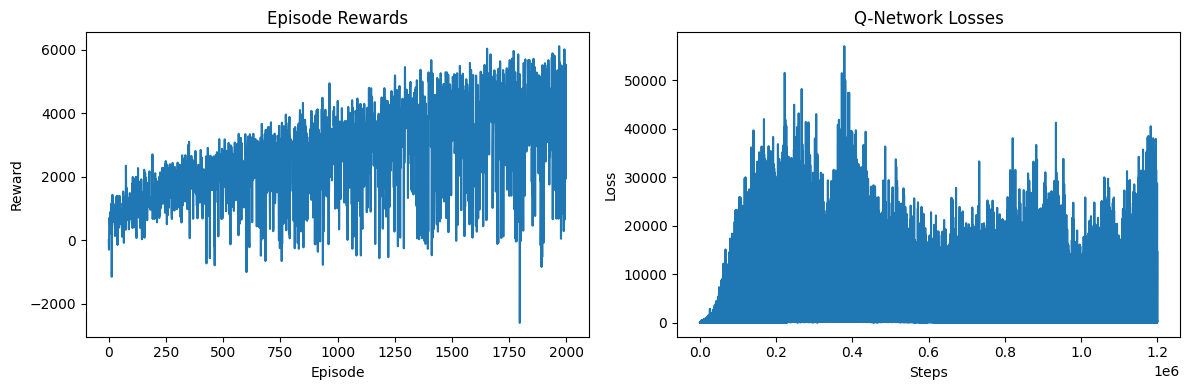

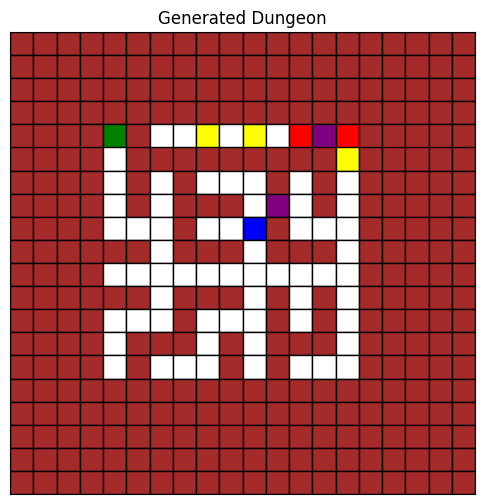

In [78]:
# Train and Visualize
if __name__ == "__main__":
    trained_agent, trained_envs = train_dungeon_generator(num_episodes=10)
    generated_dungeon = generate_dungeon_with_model(trained_agent, 7)
    visualize_dungeon(generated_dungeon)

Difficulty: 8


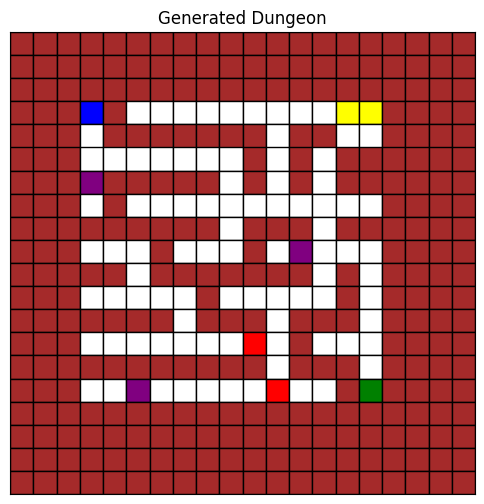

In [209]:
difficulty = 8
print(f"Difficulty: {difficulty}")
generated_dungeon = generate_dungeon_with_model(trained_agent, difficulty)
visualize_dungeon(generated_dungeon)
gen_size, gen_start_pos, gen_end_pos, gen_grid = export_dungeon(generated_dungeon)
#Level 3 -> [(9, 9), (9, 8), (9, 7), (10, 7), (9, 7), (9, 8), (9, 9), (8, 9), (8, 10), (7, 10), (7, 9), (7, 8), (7, 7)] Reached exit with 180 health.
#Level 5 -> [(12, 11), (12, 10), (11, 10), (10, 10), (9, 10), (8, 10), (8, 9), (8, 8), (9, 8), (8, 8), (8, 9), (8, 8), (8, 9), (8, 8), 
#(8, 9), (8, 8), (8, 9), (8, 10), (7, 10), (6, 10), (6, 9), (6, 8), (6, 7), (6, 6)] ✅ Reached exit with reward: 90.0

In [210]:
print(gen_size, gen_start_pos, gen_end_pos, gen_grid)

(20, 20) (3, 3) (15, 15) [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 5 1 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1]
 [1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1]
 [1 1 1 6 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1]
 [1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1]
 [1 1 1 0 0 0 1 0 0 0 1 0 6 0 0 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1]
 [1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1]
 [1 1 1 0 0 0 0 0 0 0 2 0 1 0 0 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1]
 [1 1 1 0 0 6 0 0 0 0 0 2 0 0 1 4 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


In [167]:
import numpy as np
import random
from collections import deque
 
# Define map elements
EMPTY = 0
WALL = 1
LAVA = 2
TREASURE = 3
EXIT = 4
START = 5
ENEMY = 6
 
class DungeonSolverQLearning:
    def __init__(self, dungeon, start, goal, alpha=0.7, gamma=0.3, epsilon=1, episodes=100000):
        self.original_dungeon = np.copy(dungeon)
        self.dungeon = np.copy(dungeon)
        self.start = start
        self.goal = goal
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.episodes = episodes
        self.q_table = np.zeros((*dungeon.shape, 4))
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
 
        self.rewards = {
            EMPTY: -0.1,
            WALL: -1000,
            LAVA: -1000,
            TREASURE: 50,
            EXIT: 100,
            START: 0,
            ENEMY: -20
        }
 
    def train(self):
        max_steps = 400  # Limit per episode
 
        for episode in range(self.episodes):
            self.dungeon = np.copy(self.original_dungeon)
            x, y = self.start
            health = 100
            steps = 0
 
            while (x, y) != self.goal and steps < max_steps:
                steps += 1
 
                if random.uniform(0, 1) < self.epsilon:
                    action = random.choice(range(4))  # Explore
                else:
                    action = np.argmax(self.q_table[x, y])  # Exploit
 
                dx, dy = self.actions[action]
                nx, ny = x + dx, y + dy
 
                if 0 <= nx < self.dungeon.shape[0] and 0 <= ny < self.dungeon.shape[1]:
                    cell_type = self.dungeon[nx, ny]
                
                    # ❌ Hard block on walls and lava
                    if cell_type == WALL or cell_type == LAVA:
                        # Learn not to go there, but do not move
                        self.q_table[x, y, action] = -1000  # Hardcoded punishment
                        continue  # Do not move into this tile!
                
                    # ✅ Safe to move
                    reward = self.rewards.get(cell_type, -1)
                
                    if cell_type == TREASURE:
                        reward += 100
                        self.dungeon[nx, ny] = EMPTY
                
                    max_future_q = np.max(self.q_table[nx, ny])
                    self.q_table[x, y, action] = (1 - self.alpha) * self.q_table[x, y, action] + \
                                                 self.alpha * (reward + self.gamma * max_future_q)
                
                    x, y = nx, ny


 
            self.epsilon = max(0.01, self.epsilon * 0.99999)
 
 
    def solve(self):
        path = []
        x, y = self.start
        self.dungeon = np.copy(self.original_dungeon)
        visited = set()
        episode_visit_counts = np.zeros_like(self.dungeon)
        steps = 0
        max_steps = 400
        recent_positions = deque(maxlen=10)
        total_reward = 0
    
        while steps < max_steps:
            path.append((x, y))
            visited.add((x, y))
            recent_positions.append((x, y))
            steps += 1
    
            episode_visit_counts[x, y] += 1
            if episode_visit_counts[x, y] > 3:
                total_reward -= 1  # discourage staying in same spot too long
    
            # 🔁 Loop detection and random escape
            if len(recent_positions) == recent_positions.maxlen:
                unique = set(recent_positions)
                if len(unique) <= 3:
                    legal_actions = [
                        i for i in range(4)
                        if 0 <= x + self.actions[i][0] < self.dungeon.shape[0] and
                           0 <= y + self.actions[i][1] < self.dungeon.shape[1] and
                           self.dungeon[x + self.actions[i][0], y + self.actions[i][1]] != WALL
                    ]
                    if legal_actions:
                        action = random.choice(legal_actions)
                        dx, dy = self.actions[action]
                        x, y = x + dx, y + dy
                        total_reward -= 2  # penalty for random jump escape
                        continue
                    else:
                        return path, f"🔁 Stuck in a loop at {(x, y)} — no valid exits."
    
            # ✅ Force exit if adjacent
            for dx, dy in self.actions:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.dungeon.shape[0] and 0 <= ny < self.dungeon.shape[1]:
                    if self.dungeon[nx, ny] == EXIT:
                        path.append((nx, ny))
                        total_reward += self.rewards[EXIT]
                        return path, f"✅ Reached exit with reward: {total_reward}"
    
            # 💡 Evaluate possible moves
            possible_moves = {}
            treasure_moves = []
    
            for i, (dx1, dy1) in enumerate(self.actions):
                nx1, ny1 = x + dx1, y + dy1
                if 0 <= nx1 < self.dungeon.shape[0] and 0 <= ny1 < self.dungeon.shape[1]:
                    if self.dungeon[nx1, ny1] == WALL:
                        continue
    
                    q1 = self.q_table[x, y, i]
                    max_q2 = float('-inf')
    
                    for j, (dx2, dy2) in enumerate(self.actions):
                        nx2, ny2 = nx1 + dx2, ny1 + dy2
                        if 0 <= nx2 < self.dungeon.shape[0] and 0 <= ny2 < self.dungeon.shape[1]:
                            if self.dungeon[nx2, ny2] != WALL:
                                q2 = self.q_table[nx1, ny1, j]
                                max_q2 = max(max_q2, q2)
    
                    value = q1 + self.gamma * max_q2
    
                    # ➕ Direction bonus
                    dist_before = np.linalg.norm([x - self.goal[0], y - self.goal[1]])
                    dist_after = np.linalg.norm([nx1 - self.goal[0], ny1 - self.goal[1]])
                    value += (dist_before - dist_after) * 4
    
                    # ➖ Revisiting penalty
                    if self.dungeon[nx1, ny1] == EMPTY and (nx1, ny1) in visited:
                        value -= 5
    
                    possible_moves[i] = value
    
                    if self.dungeon[nx1, ny1] == TREASURE:
                        treasure_moves.append(i)
    
            if not possible_moves:
                return path, f"🚫 No valid moves left. Total reward: {total_reward}"
    
            # 🎯 Select best move
            action = random.choice(treasure_moves) if treasure_moves else max(possible_moves, key=possible_moves.get)
            dx, dy = self.actions[action]
            nx, ny = x + dx, y + dy
    
            cell_type = self.dungeon[nx, ny]
    
            # ❌ Final WALL check
            if cell_type == WALL:
                return path, f"🚧 Solver tried to walk into a wall at {(nx, ny)}."
    
            # 🔥 LAVA: end run
            if cell_type == LAVA:
                total_reward += self.rewards[LAVA]
                return path, f"🔥 Fell into lava at {(nx, ny)}. Total reward: {total_reward}"
    
            # 😈 ENEMY penalty
            if cell_type == ENEMY:
                total_reward += self.rewards[ENEMY]
    
            # 💰 TREASURE collection
            if cell_type == TREASURE:
                print(f"💰 Collected treasure at {(nx, ny)}")
                total_reward += self.rewards[TREASURE]
                self.dungeon[nx, ny] = EMPTY
                self.q_table[nx, ny] = np.zeros(4)
    
            # ➕ Empty / start / exit reward
            total_reward += self.rewards.get(cell_type, -1)
    
            x, y = nx, ny
    
            # ✅ Exit tile
            if self.dungeon[x, y] == EXIT:
                path.append((x, y))
                total_reward += self.rewards[EXIT]
                return path, f"✅ Reached exit with reward: {total_reward}"
    
        path.append((x, y))
        return path, f"⏱️ Did not reach exit. Total reward: {total_reward}"

 
def solve_generated_level(dungeon, start, goal):
    solver = DungeonSolverQLearning(dungeon, start, goal)
    solver.train()
    return solver.solve()

In [183]:
def print_traced_grid(dungeon, path):
    traced = dungeon.copy().astype(str)

    # Optional: define visual symbols
    symbols = {
        '0': '.',  # EMPTY
        '1': '#',  # WALL
        '2': '~',  # LAVA
        '3': '$',  # TREASURE
        '4': 'E',  # EXIT
        '5': 'S',  # START
        '6': 'X'   # ENEMY
    }

    # Replace cell values with visual symbols
    for i in range(traced.shape[0]):
        for j in range(traced.shape[1]):
            traced[i, j] = symbols.get(traced[i, j], '?')

    # Mark path on grid
    for idx, (x, y) in enumerate(path):
        if traced[x, y] not in ['S', 'E']:  # Don't overwrite START or EXIT
            traced[x, y] = '*'  # Path marker

    # Print grid
    print("\nTraced Path on Grid:\n")
    for row in traced:
        print(' '.join(row))


In [191]:
# main.py
import numpy as np

def read_input(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    size = tuple(map(int, lines[0].strip().split()))
    start = tuple(map(int, lines[1].strip().split()))
    goal = tuple(map(int, lines[2].strip().split()))
    dungeon = [list(map(int, line.strip().split())) for line in lines[3:]]
    return np.array(dungeon), start, goal

def write_output(filename, path, outcome):
    with open(filename, 'w') as f:
        f.write("Path:\n")
        for step in path:
            f.write(f"{step}\n")
        f.write("\nOutcome:\n")
        f.write(outcome)

if __name__ == "__main__":
    dungeon, start, goal = gen_grid, gen_start_pos, gen_end_pos
    path, outcome = solve_generated_level(dungeon, start, goal)
    print(path, outcome)
    print_traced_grid(dungeon, path)

💰 Collected treasure at (4, 15)
[(3, 15), (4, 15), (5, 15), (5, 14), (5, 13), (6, 13), (7, 13), (8, 13), (9, 13), (9, 14), (9, 13), (8, 13), (9, 13), (8, 13), (9, 13), (8, 13), (9, 13), (9, 14), (9, 15), (9, 14), (9, 13), (8, 13), (9, 13), (8, 13), (9, 13), (8, 13), (9, 13), (8, 13), (9, 13), (9, 14), (9, 13), (9, 12)] 🔥 Fell into lava at (9, 11). Total reward: -966.4000000000001

Traced Path on Grid:

# # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # #
# # # . # . . . . . . . . . . S # . # #
# # # . # . # # # # # . # # # * X . # #
# # # ~ # X # . # ~ # . # * * * # . # #
# # # . # . # . # . # # # * # # # . # #
# # # X # . # . # . # . # * . . . . # #
# # # ~ # . # . # . # . # * # # # . # #
# # # . # . # . # . . ~ * * * * # . # #
# # # . # . # ~ # . # # # # # # # # # #
# # # . . . . . . . . . . . . . . . # #
# # # . # . # # # # # # # # # # # # # #
# # # . # . . . # . # . . . # . # . # #
# # # # # . # # # . # ~ # # # ~ # 

Difficulty: 9


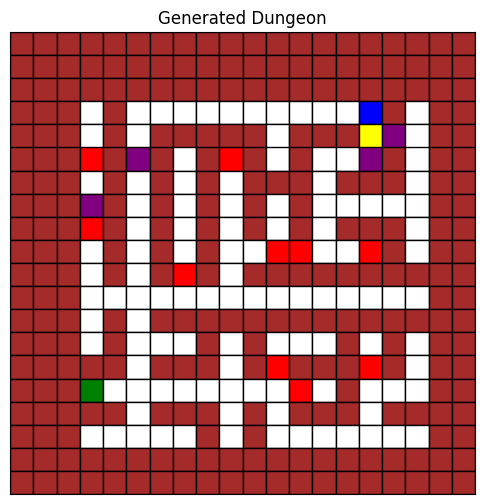

In [189]:
difficulty = 9
print(f"Difficulty: {difficulty}")
generated_dungeon = generate_dungeon_with_model(trained_agent, difficulty)
visualize_dungeon(generated_dungeon)
gen_size, gen_start_pos, gen_end_pos, gen_grid = export_dungeon(generated_dungeon)

In [190]:
print(gen_size, gen_start_pos, gen_end_pos, gen_grid)

(20, 20) (3, 15) (15, 3) [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 5 1 0 1 1]
 [1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 3 6 0 1 1]
 [1 1 1 2 1 6 1 0 1 2 1 0 1 0 0 6 1 0 1 1]
 [1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1]
 [1 1 1 6 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1]
 [1 1 1 2 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1]
 [1 1 1 0 1 0 1 0 1 0 0 2 2 0 0 2 1 0 1 1]
 [1 1 1 0 1 0 1 2 1 0 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1]
 [1 1 1 1 1 0 1 1 1 0 1 2 1 1 1 2 1 0 1 1]
 [1 1 1 4 0 0 0 0 0 0 0 0 2 0 1 0 0 0 1 1]
 [1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1]
 [1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
